In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary
from torchvision import transforms
from torchmetrics import Accuracy, Precision, Recall


In [15]:
# Hyperparameters for all models
batch_size = 32
num_of_classes = 10
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
dim = 32

# Data augmentation and normalization for training
train_transform = transforms.Compose([ 
    transforms.Resize((dim, dim)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),  # TODO: See what this does
])

# Just normalization for validation
test_transform = transforms.Compose([
    transforms.Resize((dim, dim)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])


In [17]:

train_ratio = 0.8

# Loading the Datasets CIFAR 10
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=test_transform)
# Splitting the dataset into training and validation
train_size = int(train_ratio * len(cifar_dataset))
val_size = len(cifar_dataset) - train_size
indices = torch.randperm(len(cifar_dataset))

train_dataset = torch.utils.data.Subset(train_dataset, indices[:train_size])
val_dataset = torch.utils.data.Subset(val_dataset, indices[train_size:])


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2 )
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# Loading the test dataset and creating a dataloader
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [18]:
print(len(cifar_dataset),len(train_dataset),len(val_dataset),len(test_dataset))

50000 40000 10000 10000


In [19]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


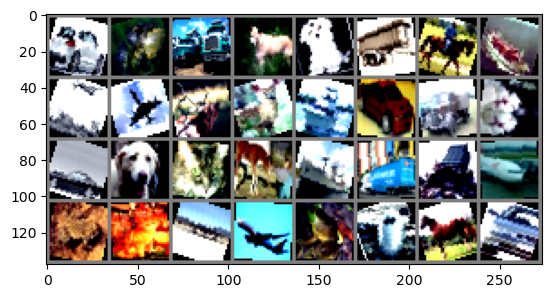

In [20]:
image, label = next(iter(train_loader))
imshow(torchvision.utils.make_grid(image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


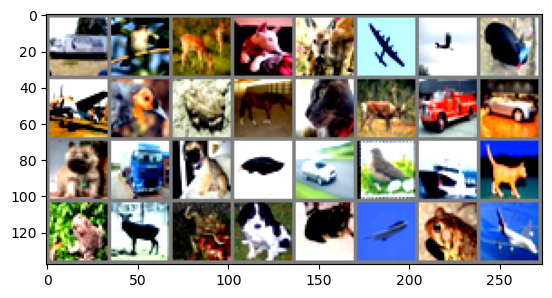

In [21]:
image, label = next(iter(val_loader))
imshow(torchvision.utils.make_grid(image))

## **Model 1**
- **Just change the feature_extract and classifier to the model you want to use.**

In [91]:


# Model 1
class FirstModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        # Debugging
        self.DEBUG = False
        # Hyperparameters
        self.num_epochs = 10
        self.learning_rate = 0.001

        # History while Training
        self.model_loss_history = []
        self.model_train_acc_history = []
        self.model_val_acc_history = []
        self.model_val_precision_history = []
        self.model_val_recall_history = []
        self.model_lr_history = []

        # Model Attributes
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = None
        self.accuracy = Accuracy(task= 'multiclass', num_classes=num_of_classes, average='macro').to(device)
        self.precision = Precision(task= 'multiclass', num_classes=num_of_classes, average='macro').to(device)
        self.recall = Recall(task= 'multiclass', num_classes=num_of_classes, average='macro').to(device)

        # Model Architecture
        self.feature_extract = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            
            # nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),            
        )
        
    def forward(self, x):
        x = self.feature_extract(x)
        x = self.classifier(x)
        return x
    
    def predict(self, img):
        '''
        returns the predicted classes for the given images
        '''
        self.eval()
        with torch.no_grad():
            img = img.to(device)
            output = self(img)
            _, predicted = torch.max(output, 1)
            return predicted
        

    
    def eval_val(self, data_loader):
        '''
        returns accuracy, precision and recall
        '''
        self.eval()
        with torch.no_grad():
            for images, labels in data_loader:
                
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                self.accuracy(outputs, labels)
                self.precision(outputs, labels)
                self.recall(outputs, labels)

        return self.accuracy.compute(), self.precision.compute(), self.recall.compute()
    
    def train_model(self, train_loader, val_loader):

        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        for epoch in range(self.num_epochs):
            self.train()
            running_loss = 0.0

            for i, (images, labels) in enumerate(train_loader):

                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                if i%100 == 0 and self.DEBUG:
                    print(" Step [{}/{}] Loss: {}".format(i, len(train_loader), loss.item()))
                    
            val_acc, val_precision, val_recall = self.eval_val(val_loader)
            train_acc, _, _ = self.eval_val(train_loader)

            self.model_loss_history.append(running_loss/len(train_loader))
            self.model_train_acc_history.append(train_acc.item())
            self.model_val_acc_history.append(val_acc.item())
            self.model_val_precision_history.append(val_precision.item())
            self.model_val_recall_history.append(val_recall.item())
            self.model_lr_history.append(self.optimizer.param_groups[0]['lr'])

            print(f'Epoch: {epoch+1}/{self.num_epochs}, Loss: {loss.item()},Train Acc: {train_acc}, Val Acc: {val_acc}, Val Precision: {val_precision}, Val Recall: {val_recall}')
        
        print('Finished Training')

    def plot_history(self):
        # making two plots one for loss and other for accuracy
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Model Training History')
        axs[0, 0].plot(self.model_loss_history)
        axs[0, 0].set_title('Model Loss')
        axs[0, 0].set_xlabel('Epochs')
        axs[0, 0].set_ylabel('Loss')

        axs[0, 1].plot(self.model_train_acc_history, label='Train')
        axs[0, 1].plot(self.model_val_acc_history, label='Val')
        axs[0, 1].set_title('Model Accuracy')
        axs[0, 1].set_xlabel('Epochs')
        axs[0, 1].set_ylabel('Accuracy')
        axs[0, 1].legend()

        axs[1, 0].plot(self.model_val_precision_history)
        axs[1, 0].set_title('Model Precision')
        axs[1, 0].set_xlabel('Epochs')
        axs[1, 0].set_ylabel('Precision')
        
        axs[1, 1].plot(self.model_val_recall_history)
        axs[1, 1].set_title('Model Recall')
        axs[1, 1].set_xlabel('Epochs')
        axs[1, 1].set_ylabel('Recall')

        axs[0, 2].plot(self.model_lr_history)
        axs[0, 2].set_title('Learning Rate')
        axs[0, 2].set_xlabel('Epochs')
        axs[0, 2].set_ylabel('Learning Rate')
        
        
        # axs[1, 2].axis('off')

        plt.show()
    
    def save_model(self):
        torch.save(self.state_dict(), 'model.pth')

    def print_summary(self):
        summary(self, (3, dim, dim))


### **END of Model 1**
### **Start of Model 2**

In [142]:
class SecondModel(FirstModel):
    def __init__(self, num_of_classes):
        super().__init__(num_of_classes)
        self.dropout_ratio = .2
        self.feature_extract = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten()
            )
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_of_classes),            
        )
    
    def train_model(self, train_loader, val_loader):

        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        for epoch in range(self.num_epochs + 25):
            self.train()
            running_loss = 0.0

            for i, (images, labels) in enumerate(train_loader):

                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                if i%100 == 0 and self.DEBUG:
                    print(" Step [{}/{}] Loss: {}".format(i, len(train_loader), loss.item()))
                    
            val_acc, val_precision, val_recall = self.eval_val(val_loader)
            train_acc, _, _ = self.eval_val(train_loader)

            self.model_loss_history.append(running_loss/len(train_loader))
            self.model_train_acc_history.append(train_acc.item())
            self.model_val_acc_history.append(val_acc.item())
            self.model_val_precision_history.append(val_precision.item())
            self.model_val_recall_history.append(val_recall.item())
            self.model_lr_history.append(self.optimizer.param_groups[0]['lr'])

            print(f'Epoch: {epoch+1}/{self.num_epochs}, Loss: {loss.item()},Train Acc: {train_acc}, Val Acc: {val_acc}, Val Precision: {val_precision}, Val Recall: {val_recall}')
        
        print('Finished Training')
    

In [90]:

model_one = FirstModel(num_of_classes).to(device)
model_one.print_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          51,264
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]          18,464
       BatchNorm2d-8             [-1, 32, 8, 8]              64
         MaxPool2d-9             [-1, 32, 4, 4]               0
          Flatten-10                  [-1, 512]               0
           Linear-11                  [-1, 128]          65,664
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 139,370
Trainable params:

In [24]:

# Training the Model
model_one.train_model(train_loader, val_loader)


Epoch: 1/10, Loss: 1.4004442691802979,Train Acc: 0.5695800185203552, Val Acc: 0.5779653787612915, Val Precision: 0.5795019865036011, Val Recall: 0.5779653787612915
Epoch: 2/10, Loss: 1.2318005561828613,Train Acc: 0.5936499834060669, Val Acc: 0.5785634517669678, Val Precision: 0.5774400234222412, Val Recall: 0.5785634517669678
Epoch: 3/10, Loss: 0.9967765212059021,Train Acc: 0.6167333126068115, Val Acc: 0.600252628326416, Val Precision: 0.600246787071228, Val Recall: 0.600252628326416
Epoch: 4/10, Loss: 0.8246172070503235,Train Acc: 0.6316900253295898, Val Acc: 0.6200413703918457, Val Precision: 0.6225075721740723, Val Recall: 0.6200413703918457
Epoch: 5/10, Loss: 0.6560429930686951,Train Acc: 0.6449719667434692, Val Acc: 0.6344012022018433, Val Precision: 0.6350219249725342, Val Recall: 0.6344012022018433
Epoch: 6/10, Loss: 0.8082633018493652,Train Acc: 0.6571600437164307, Val Acc: 0.6474810838699341, Val Precision: 0.6464909911155701, Val Recall: 0.6474810838699341
Epoch: 7/10, Loss: 

In [25]:
# Evaluating the Model
acc, prec, rec = model_one.eval_val(test_loader)
print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}')

Accuracy: 0.6890882253646851, Precision: 0.6882021427154541, Recall: 0.6890882253646851


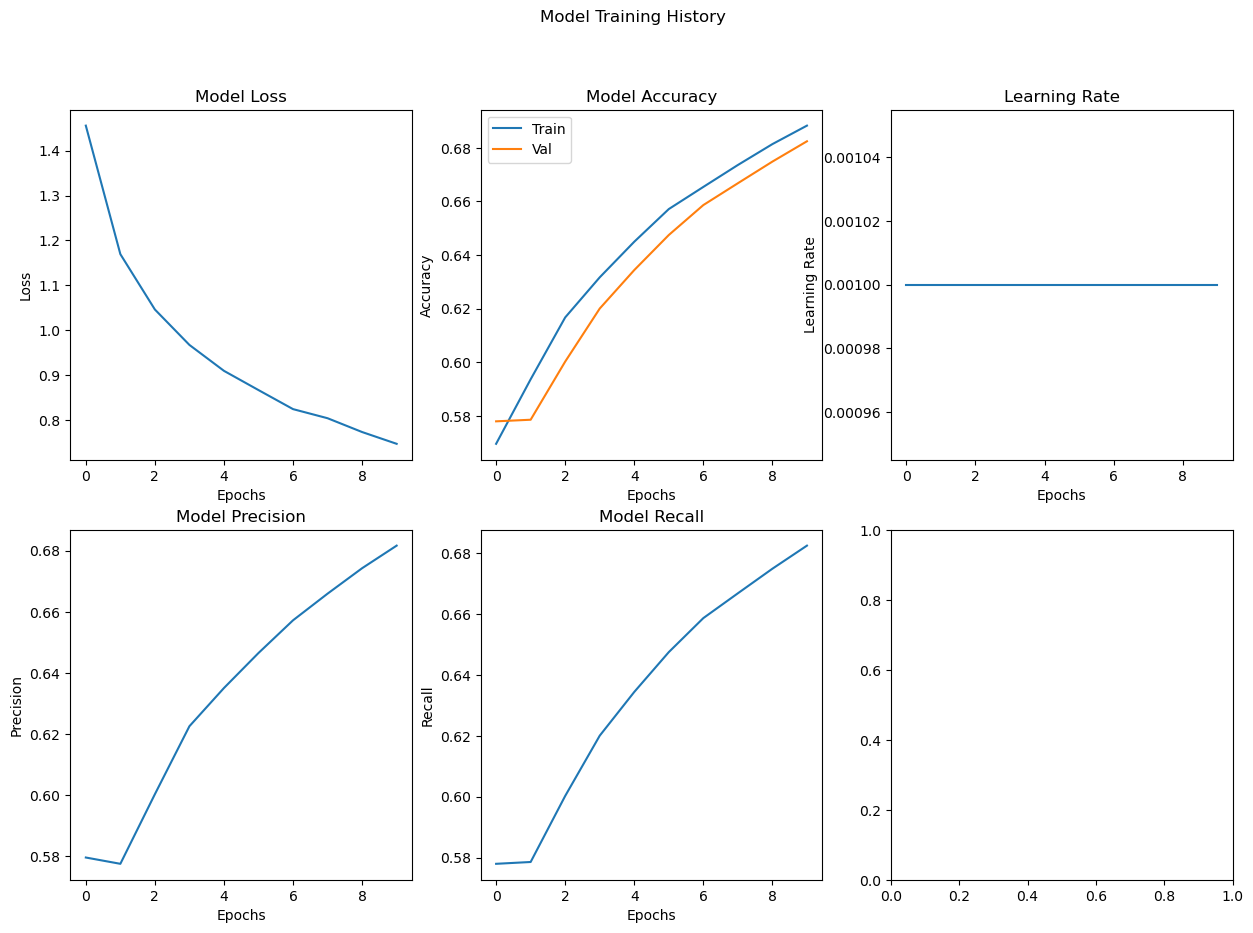

In [26]:
# Plotting the History
model_one.plot_history()

In [27]:
# Function to display images in a grid
def display_images_grid(images, labels, predicted_labels, num_rows=3, num_cols=3, fig_size=(10, 10)):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=fig_size)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < len(images):
                axs[i, j].imshow(images[index].permute(1, 2, 0))
                if(labels[index] == predicted_labels[index]):
                    axs[i, j].set_title(f"Actual: {classes[labels[index]]}, Predicted: {classes[predicted_labels[index]]}", color='green')
                else:
                    axs[i, j].set_title(f"Actual: {classes[labels[index]]}, Predicted: {classes[predicted_labels[index]]}", color='red')
                axs[i, j].axis('off')
            else:
                axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

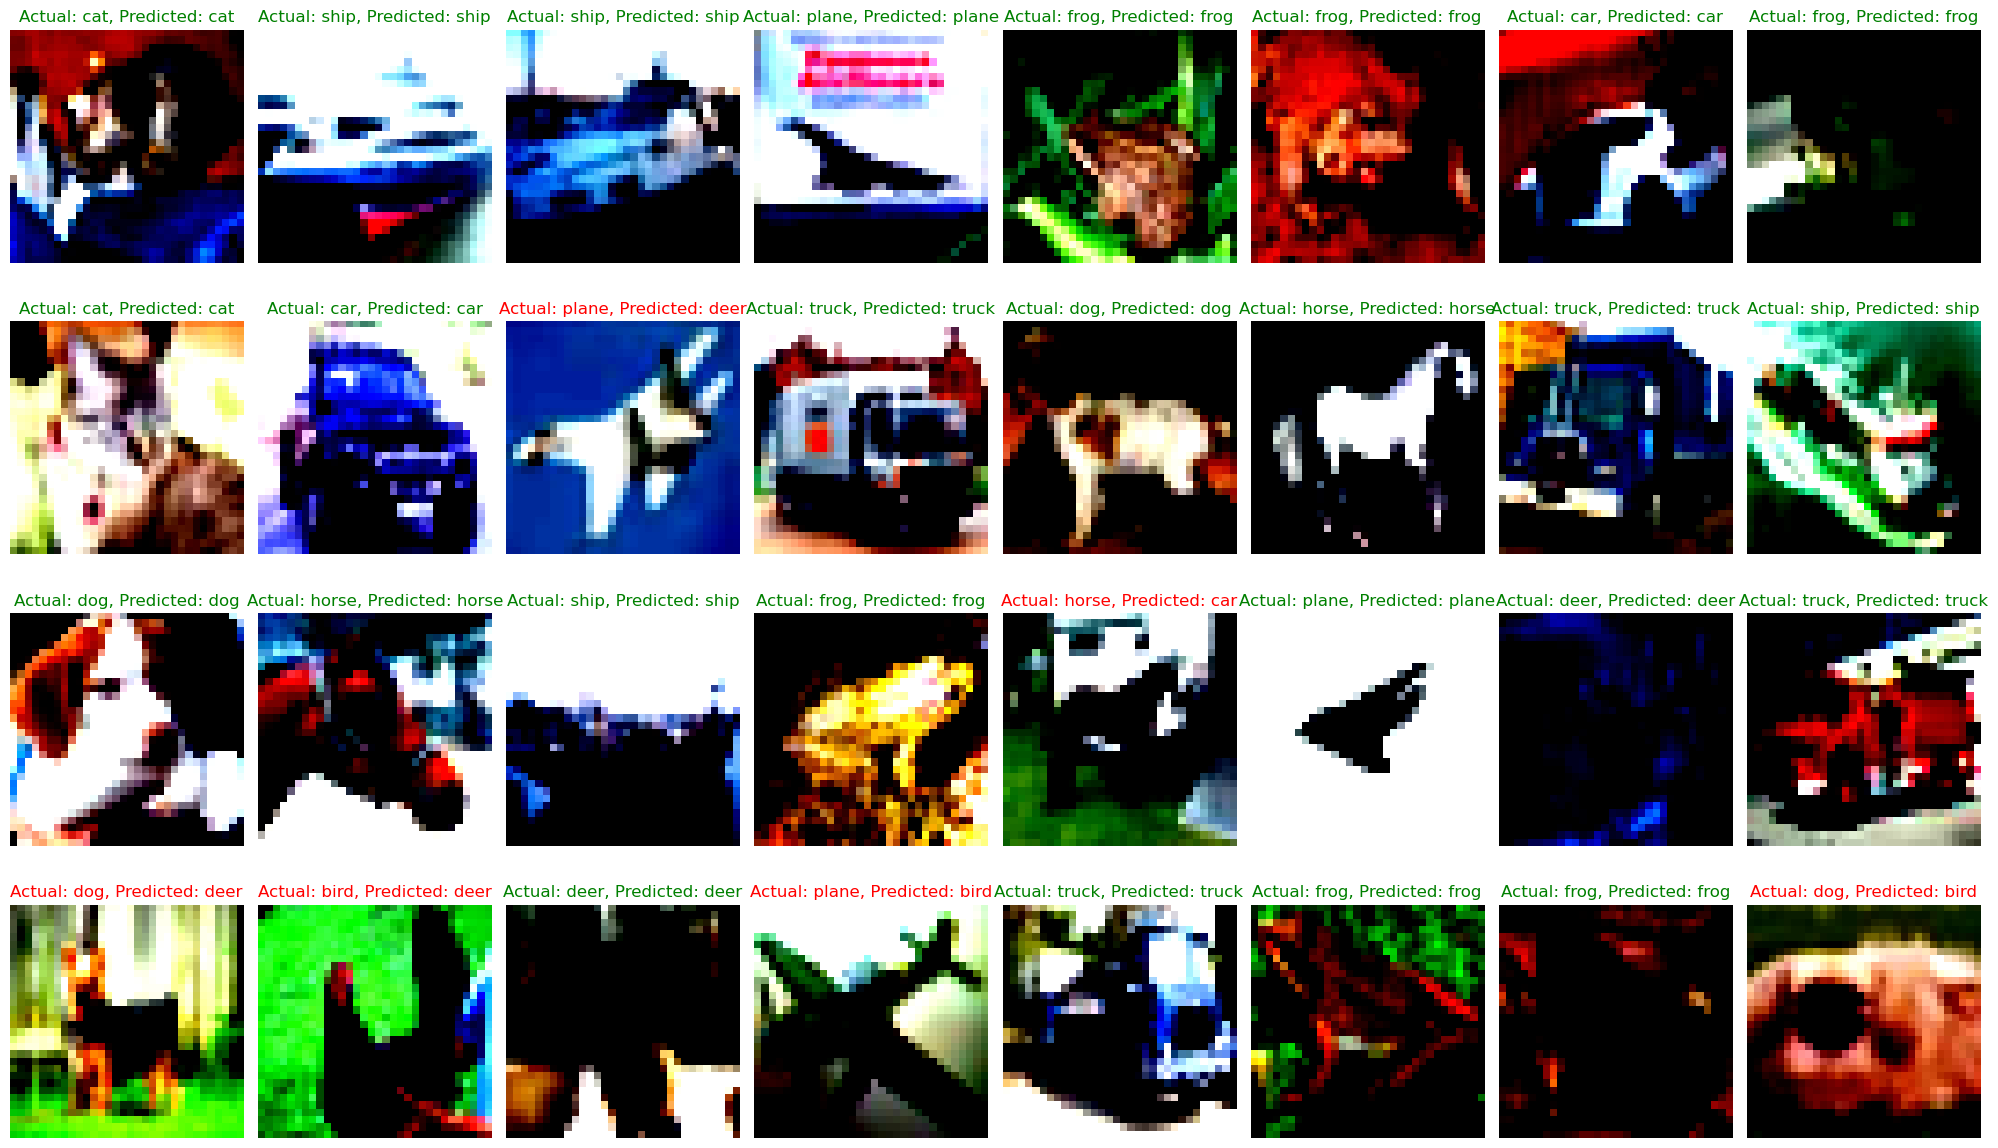

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Random Testing
image, label = next(iter(test_loader))
predicted = model_one.predict(image)
predicted = predicted.cpu().numpy()
label = label.numpy()
display_images_grid(image, label, predicted, num_rows=4, num_cols=8, fig_size=(20, 12))



Model 2 

In [ ]:
model_two = SecondModel(num_of_classes).to(device)
model_two.print_summary()
model_two.train_model(train_loader, val_loader)
acc, prec, rec = model_two.eval_val(test_loader)
print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}')
model_two.plot_history()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          51,264
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]          18,464
       BatchNorm2d-8             [-1, 32, 8, 8]              64
         MaxPool2d-9             [-1, 32, 4, 4]               0
          Flatten-10                  [-1, 512]               0
           Linear-11                  [-1, 256]         131,328
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [